In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
g = torch.Generator().manual_seed(2147483647)

In [4]:
words = open('names.txt','r').read().splitlines()
#words[:8]
#Building the vocabulary of characters and mappings to integrers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)


{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [5]:
#building the dataset
block_size = 3
def build_dataset(words):
        #context length : characters taken to predict the next one
    X, Y = [], []

    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]      #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        #buffers (training with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):

        if self.training:
            xmean = x.mean(0, keepdim=True)     #bacth mean
            xvar = x.var(0, keepdim = True)     #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x-xmean)/ torch.sqrt(xvar + self.eps)       #normalizing to unit variance
        self.out = self.gamma * xhat + self.beta

        #updating buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    


In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),       generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size)
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():

    layers[-1].gamma *= 0.1

    #appling gain to all other layers (except last)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46912


In [9]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], y_train[ix]

    #forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)      #concatinitng the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #update step
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #tracking stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization



      0/ 200000: 3.2813
  10000/ 200000: 2.0285
  20000/ 200000: 2.1098
  30000/ 200000: 2.1545
  40000/ 200000: 2.1917
  50000/ 200000: 2.2896
  60000/ 200000: 2.2385
  70000/ 200000: 1.9692
  80000/ 200000: 2.0418
  90000/ 200000: 2.4495
 100000/ 200000: 1.9275
 110000/ 200000: 2.1910
 120000/ 200000: 1.6840
 130000/ 200000: 1.9426
 140000/ 200000: 1.9839
 150000/ 200000: 2.5172
 160000/ 200000: 1.9381
 170000/ 200000: 1.8072
 180000/ 200000: 2.3100
 190000/ 200000: 1.6712


layer 2 (      Tanh): mean +0.47, std 0.58, saturated: 22.97%
layer 5 (      Tanh): mean +0.50, std 0.58, saturated: 25.25%
layer 8 (      Tanh): mean +0.53, std 0.59, saturated: 26.34%
layer 11 (      Tanh): mean +0.56, std 0.58, saturated: 26.16%
layer 14 (      Tanh): mean +0.59, std 0.59, saturated: 30.03%


Text(0.5, 1.0, 'activation distribution')

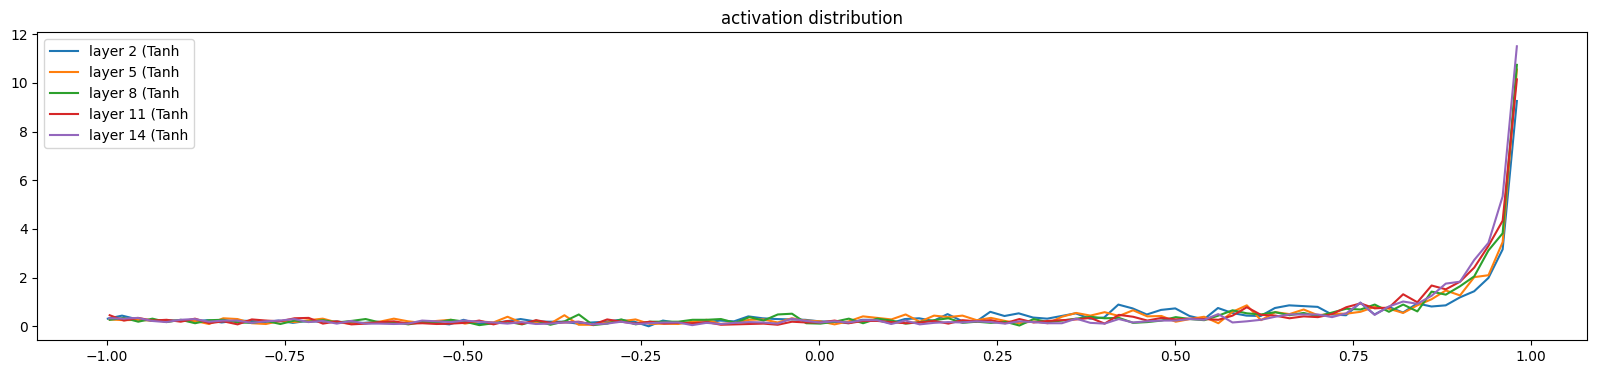

In [10]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 4.648960e-03
layer 5 (      Tanh): mean -0.000000, std 3.767475e-03
layer 8 (      Tanh): mean -0.000000, std 3.422900e-03
layer 11 (      Tanh): mean +0.000000, std 3.279457e-03
layer 14 (      Tanh): mean -0.000000, std 4.115175e-03


Text(0.5, 1.0, 'gradient distribution')

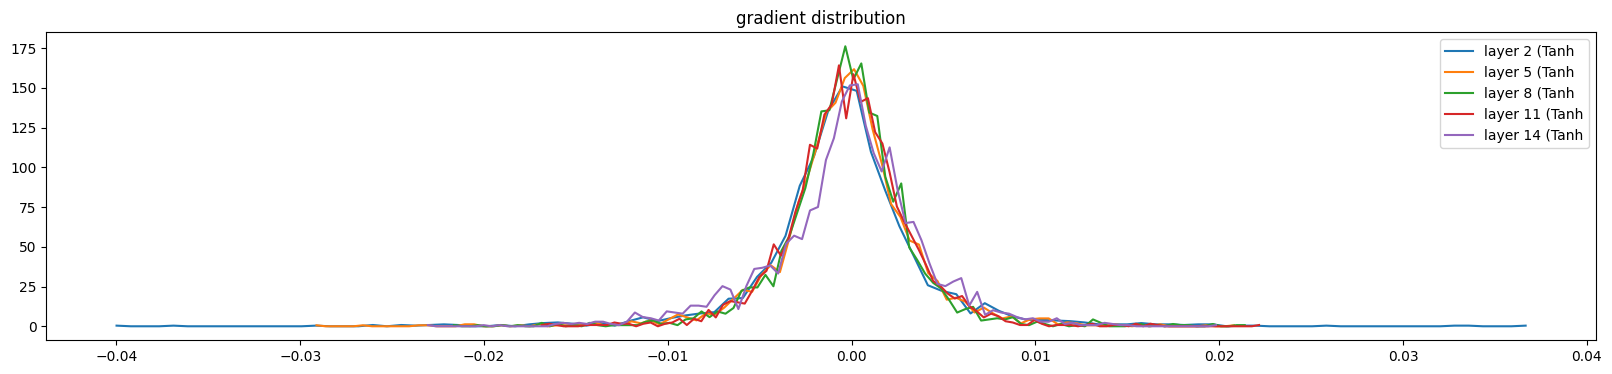

In [11]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (26, 10) | mean +0.000000 | std 1.356208e-02 | grad:data ratio 1.198720e-02
weight  (30, 100) | mean +0.000125 | std 8.690088e-03 | grad:data ratio 2.288092e-02
weight (100, 100) | mean -0.000001 | std 5.073110e-03 | grad:data ratio 2.167311e-02
weight (100, 100) | mean -0.000023 | std 4.399388e-03 | grad:data ratio 1.936646e-02
weight (100, 100) | mean -0.000025 | std 4.374362e-03 | grad:data ratio 2.024819e-02
weight (100, 100) | mean +0.000033 | std 4.155539e-03 | grad:data ratio 2.018675e-02
weight  (100, 26) | mean +0.000388 | std 7.092077e-03 | grad:data ratio 2.142854e-02


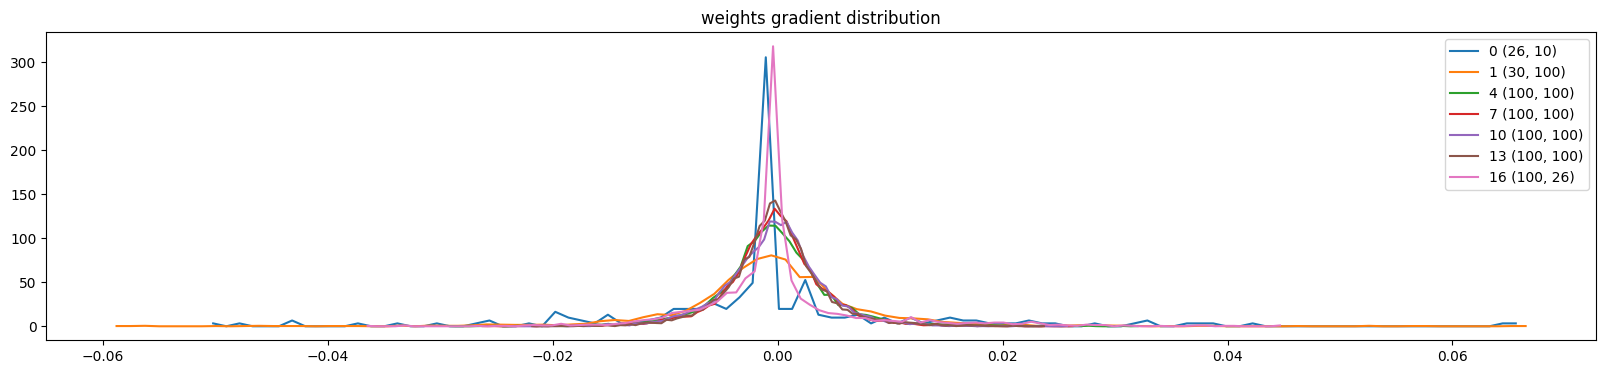

In [12]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

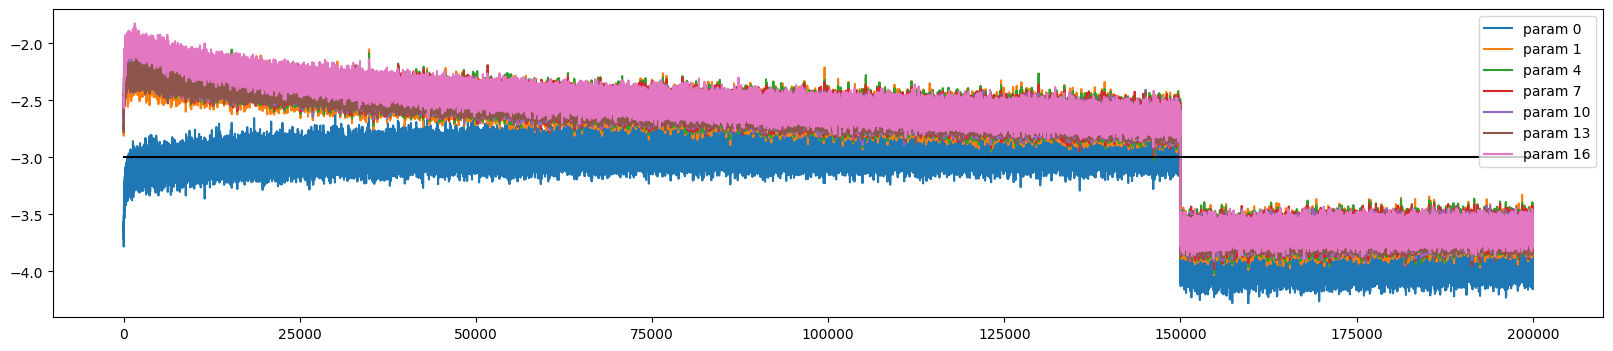

In [13]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9567327499389648
val 2.031752586364746


In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

d.
m.
felyn.
k.
zyl.
j.
.
floter.
trik.
h.
k.
.
muh.
mcc.
x.
j.
ros.
br.
ith.
l.
